# Connectivity of the free attractor study
This is a notebook to study the effects of different parameters and the connectivity between the sequence and the free attractor. The parameters that seem relevant now are:
* Epochs
* kappa dynamics
* Length of the interval between patterns
* Length of the intervals between sequences at each epoch
* Dynamics of p 
* Number of minicolumns
* Size of the free attractor
* Training time

In [42]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '36023b14afbaa6a23aff7d9e885b41a6f835ed7e'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

Now we import the functions that we use our library

In [3]:
from network import BCPNN, NetworkManager, BCPNNFast, Protocol
from data_transformer import build_ortogonal_patterns

from plotting_functions import plot_weight_matrix

from analysis_functions import calculate_total_connections, calculate_connections_free_attractor_to_first_pattern
from analysis_functions import calculate_connections_last_pattern_to_free_attractor
from analysis_functions import calculate_connections_among_free_attractor
from analysis_functions import calculate_connections_first_pattern_to_free_attractor

from analysis_functions import calculate_recall_success

In [4]:
def calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa, normalize):

    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    first_to_free = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(first_to_free)
    
def plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        parameter_range, success, parameter_range_string=None):

    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # NMDA connections
    ax1.plot(parameter_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
    ax1.plot(parameter_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
    ax1.plot(parameter_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
    ax1.plot(parameter_range, inter_free_attractor_connectivty, '*-', markersize=12, label='inter attractor')
    ax1.plot(parameter_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

    # Mirror axis
    ax1_m = ax1.twinx()
    ax1_m.plot(parameter_range, success, '--', color='k', markersize=12, label='success rate')
    ax1_m.set_ylim([-10, 140])
    ax1_m.legend(loc='lower left')

    # Ampa connections
    ax2.plot(parameter_range, inter_sequence_connectivity_ampa, '*-', markersize=12, label='inter sequence')
    ax2.plot(parameter_range, sequence_to_free_attractor_connectivity_ampa, '*-', markersize=12, label='seq to attr')
    ax2.plot(parameter_range, free_attractor_to_sequence_connectivity_ampa, '*-', markersize=12, label='attr to seq')
    ax2.plot(parameter_range, inter_free_attractor_connectivty_ampa, '*-', markersize=12, label='inter attractor')
    ax2.plot(parameter_range, first_state_to_free_attractor_connectivity_ampa, '*-', markersize=12, label='escape')

    # Mirror axis
    ax2_m = ax2.twinx()
    ax2_m.plot(parameter_range, success, '--', color='k', markersize=12, label='success rate')
    ax2_m.set_ylim([-10, 140])
    ax2_m.legend(loc='lower left')

    # Settings
    ax1.axhline(0, color='k', linewidth=2)
    ax1.set_title('NMDA')
    ax1.set_xlabel(parameter_range_string)
    # ax1.set_xlim([-1, parameter_range[-1] + 1])
    ax1.set_ylim([-3, 3])
    ax1.legend()

    ax2.axhline(0, color='k', linewidth=2)
    ax2.set_title('AMPA')
    ax2.set_xlabel(parameter_range_string)
    # ax2.set_xlim([-1, parameter_range[-1] + 1])
    ax2.set_ylim([-3, 3])
    ax2.legend()

## Epochs
First let's see the variation of the connectivity with the number of epochs

In [5]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 1

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = [i for i in range(n_patterns)]

epochs_range = np.arange(1, 20, 2, dtype='int')
n_recall = 20

In [6]:
normalize = True
ampa = False
k_inner = True
p = 1

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for epochs in epochs_range:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
       
    # Calculate correct recall
    patterns = [i for i in range(n_patterns)]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=n_recall, patterns_indexes=patterns)
    recall.append([epochs, success_rate])

../analysis_functions.py:43: RuntimeWarning: invalid value encountered in double_scalars
  dis = [a / b for (a, b) in zip(nominator, denominator)]


succesfull recall [[1, 10.0], [3, 0.0], [5, 0.0], [7, 0.0], [9, 90.0], [11, 100.0], [13, 100.0], [15, 100.0], [17, 0.0], [19, 0.0]]


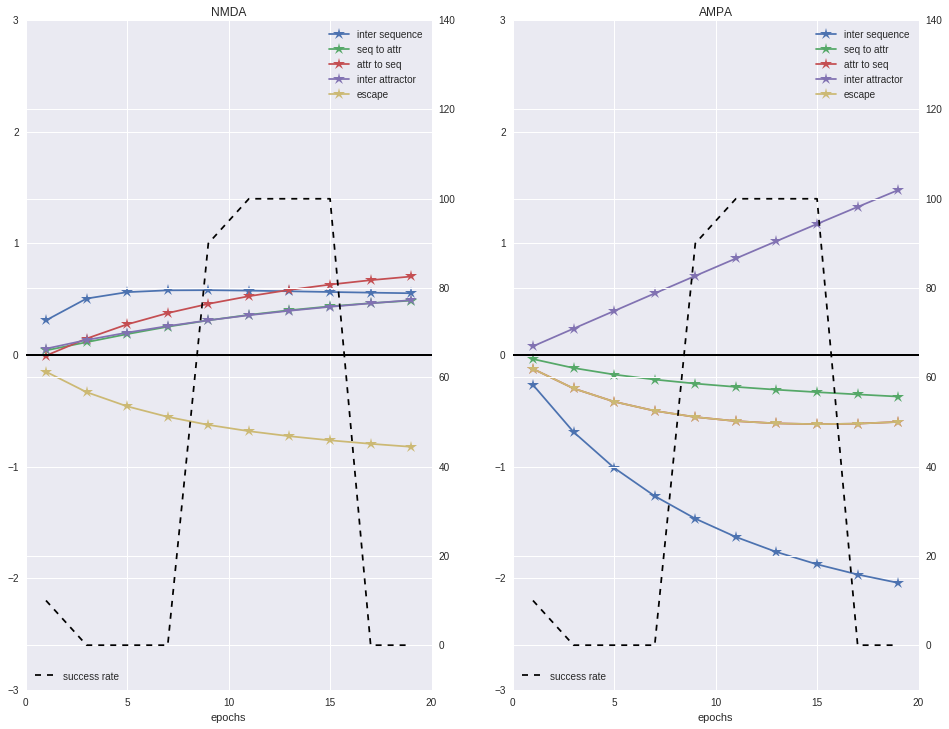

In [7]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        epochs_range, success, 'epochs')


print('succesfull recall', recall)

**Epochs, k_inner=True, p=1.0**

Here we see that we only have convergence for intermediate values of epochs. I do not understand yet the reason of this behavior. If we compare it to the graph with k_inner=False bellow we can note the following differences:
* The attractor to sequence connectivity becomes higher than the inter sequence connectivity for the NMDA matrix.
* The escape does not become as small for NMDA as it does for the other case in the figure below
* The inter attractor connectivity keeps growing for this scenario but not for the one below.
* It should be noted that for low number of epochs if the number of minicolums is increased the recollection rate increases (tried separately)

#### K inner
Let's the network keep updating the values of the probabilities even in the inter-sequence intervals

In [8]:
normalize = True
ampa = False
k_inner = False
p = 1

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for epochs in epochs_range:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=n_recall, patterns_indexes=patterns)
    recall.append([epochs, success_rate])

succesfull recall [[1, 0.0], [3, 100.0], [5, 100.0], [7, 100.0], [9, 100.0], [11, 100.0], [13, 100.0], [15, 100.0], [17, 100.0], [19, 100.0]]


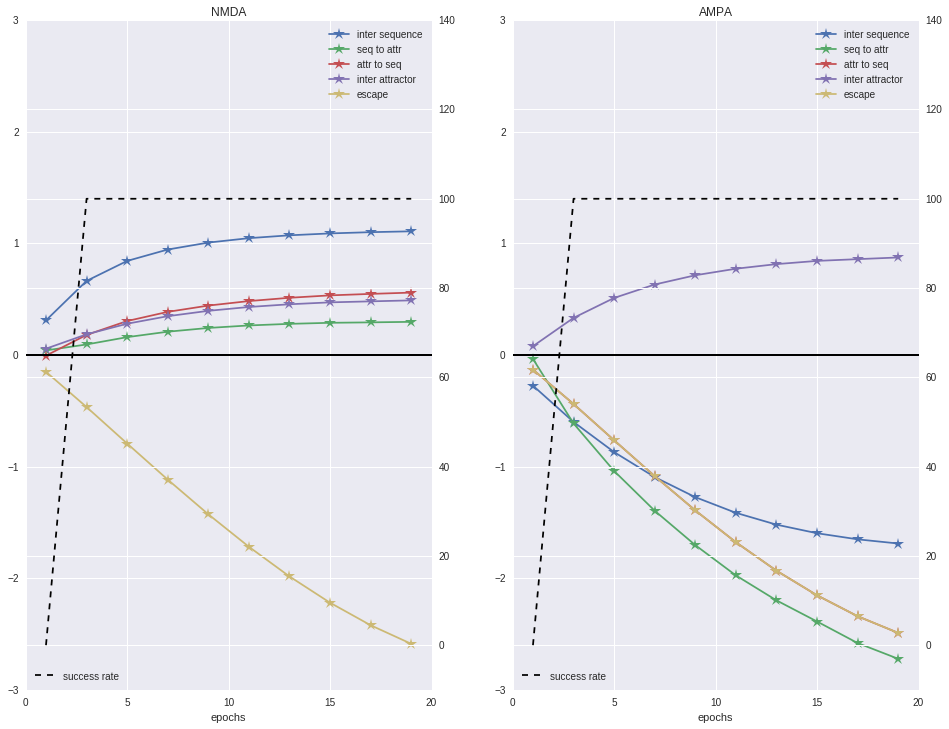

In [9]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        epochs_range, success, 'epochs')

print('succesfull recall', recall)

**Epochs, k_inner=False, p=1.0**

Here I have convergence for most of the values of epoch, is very consitent. So what is failing in the example before?

#### Effect of p 
The network effect of discounting initial effects in connectivity

In [10]:
normalize = True
ampa = False
k_inner = True
p = 0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for epochs in epochs_range:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=n_recall, patterns_indexes=patterns)
    recall.append([epochs, success_rate])

succesfull recall [[1, 5.0], [3, 100.0], [5, 15.0], [7, 0.0], [9, 100.0], [11, 100.0], [13, 100.0], [15, 100.0], [17, 0.0], [19, 0.0]]


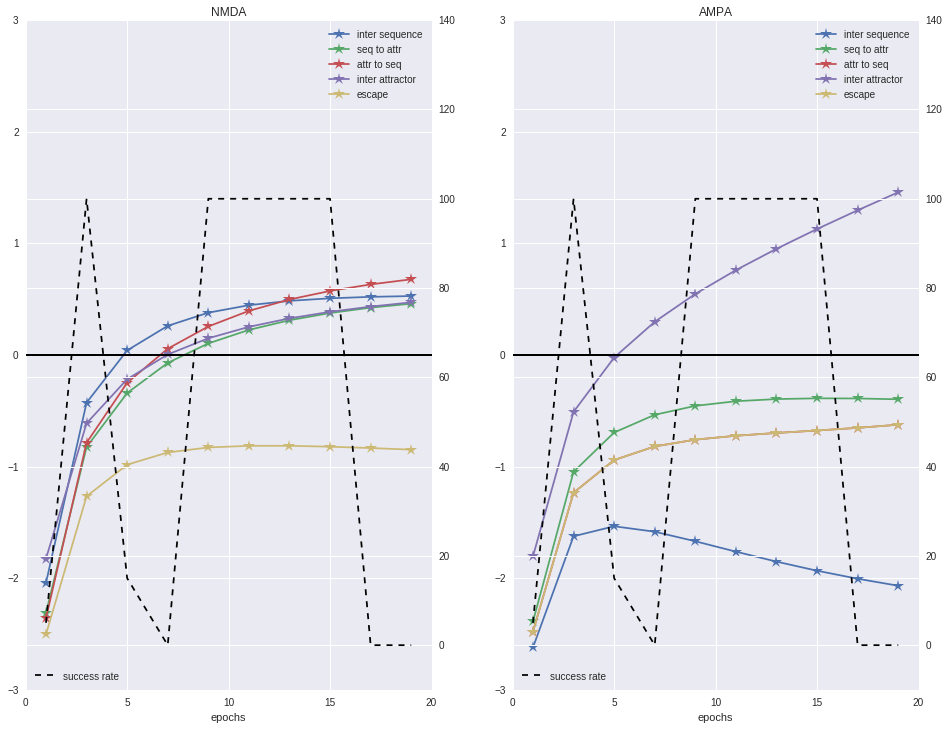

In [11]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        epochs_range, success, 'epochs')

print('succesfull recall', recall)

**Epochs, k_inner=False, p=0.0**

## Inter Sequence Interval

In [12]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 3

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = [i for i in range(n_patterns)]

inter_sequence_interval_ranges = np.arange(0, 10.5, 0.5)
n_recall = 20

In [13]:
normalize = True
ampa = False
k_inner = True
p = 1

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for inter_sequence_interval in inter_sequence_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=n_recall, patterns_indexes=patterns)
    recall.append([inter_sequence_interval, success_rate])

succesfull recall [[0.0, 20.0], [0.5, 0.0], [1.0, 0.0], [1.5, 0.0], [2.0, 10.0], [2.5, 0.0], [3.0, 0.0], [3.5, 10.0], [4.0, 0.0], [4.5, 5.0], [5.0, 5.0], [5.5, 5.0], [6.0, 10.0], [6.5, 0.0], [7.0, 10.0], [7.5, 5.0], [8.0, 10.0], [8.5, 10.0], [9.0, 0.0], [9.5, 0.0], [10.0, 5.0]]


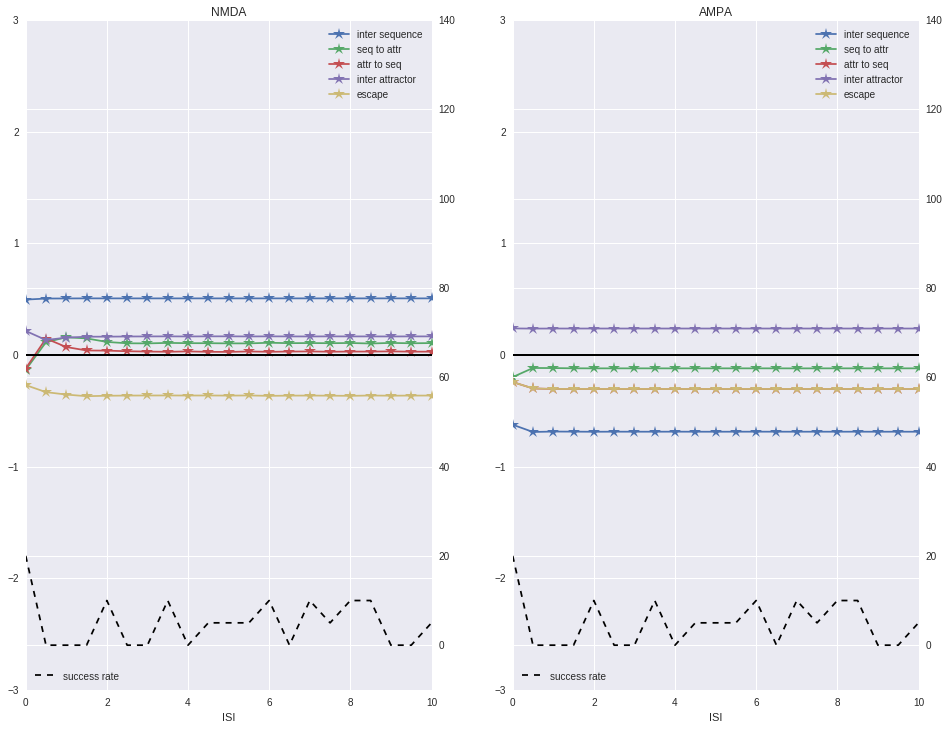

In [14]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        inter_sequence_interval_ranges, success, "ISI")

print('succesfull recall', recall)

#### Effect of k_inner

In [15]:
normalize = True
ampa = False
k_inner = False
p = 1

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []


for inter_sequence_interval in inter_sequence_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=n_recall, patterns_indexes=patterns)
    recall.append([inter_sequence_interval, success_rate])

succesfull recall [[0.0, 35.0], [0.5, 100.0], [1.0, 100.0], [1.5, 100.0], [2.0, 100.0], [2.5, 90.0], [3.0, 100.0], [3.5, 100.0], [4.0, 95.0], [4.5, 85.0], [5.0, 90.0], [5.5, 70.0], [6.0, 90.0], [6.5, 85.0], [7.0, 60.0], [7.5, 65.0], [8.0, 65.0], [8.5, 50.0], [9.0, 35.0], [9.5, 40.0], [10.0, 45.0]]


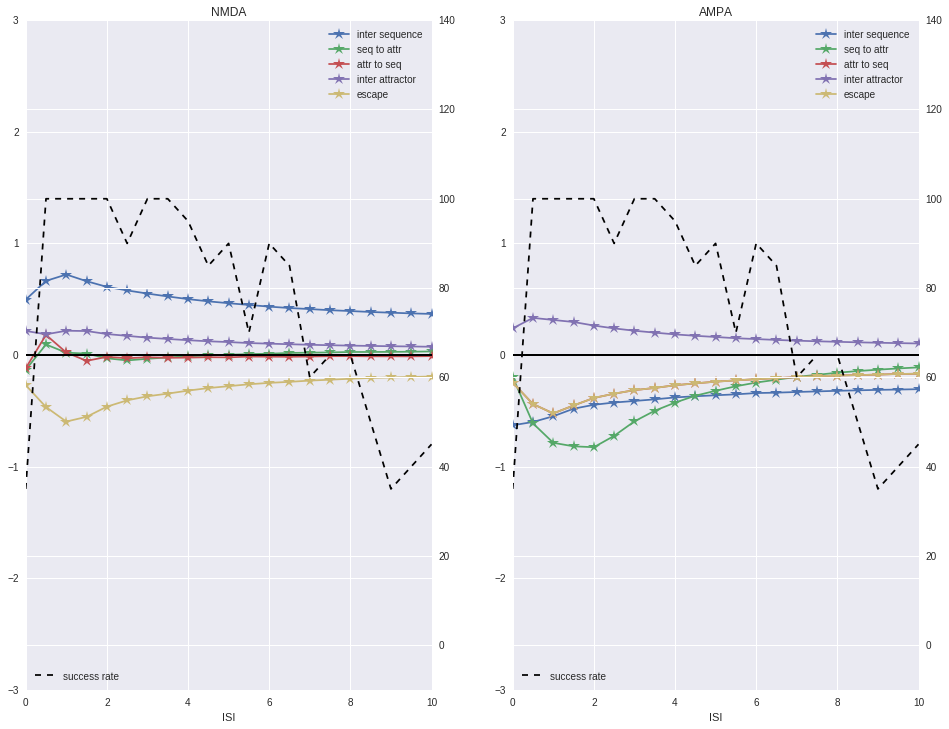

In [16]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        inter_sequence_interval_ranges, success, "ISI")

print('succesfull recall', recall)

#### Effect of p

In [17]:
normalize = True
ampa = False
k_inner = True
p = 0.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []


for inter_sequence_interval in inter_sequence_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=n_recall, patterns_indexes=patterns)
    recall.append([inter_sequence_interval, success_rate])

succesfull recall [[0.0, 100.0], [0.5, 100.0], [1.0, 75.0], [1.5, 75.0], [2.0, 50.0], [2.5, 10.0], [3.0, 15.0], [3.5, 15.0], [4.0, 10.0], [4.5, 15.0], [5.0, 15.0], [5.5, 10.0], [6.0, 5.0], [6.5, 5.0], [7.0, 5.0], [7.5, 0.0], [8.0, 5.0], [8.5, 5.0], [9.0, 5.0], [9.5, 0.0], [10.0, 0.0]]


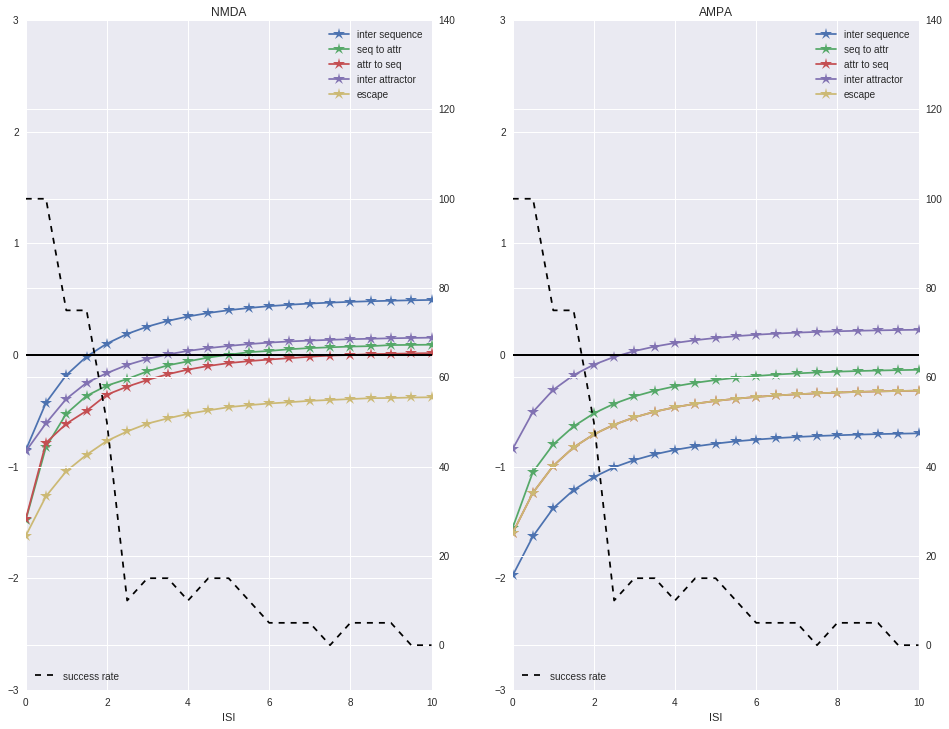

In [18]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        inter_sequence_interval_ranges, success, "ISI")

print('succesfull recall', recall)

## Inter pattern interval

In [19]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 5

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = [i for i in range(n_patterns)]

inter_pulse_interval_ranges = np.arange(0, 2.1, 0.1)

In [20]:
normalize = True
ampa = False
k_inner = True
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []


for inter_pulse_interval in inter_pulse_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([inter_pulse_interval, success_rate])

succesfull recall [[0.0, 0.0], [0.10000000000000001, 100.0], [0.20000000000000001, 100.0], [0.30000000000000004, 10.0], [0.40000000000000002, 0.0], [0.5, 0.0], [0.60000000000000009, 20.0], [0.70000000000000007, 0.0], [0.80000000000000004, 0.0], [0.90000000000000002, 0.0], [1.0, 0.0], [1.1000000000000001, 0.0], [1.2000000000000002, 0.0], [1.3, 0.0], [1.4000000000000001, 0.0], [1.5, 0.0], [1.6000000000000001, 0.0], [1.7000000000000002, 0.0], [1.8, 0.0], [1.9000000000000001, 0.0], [2.0, 0.0]]


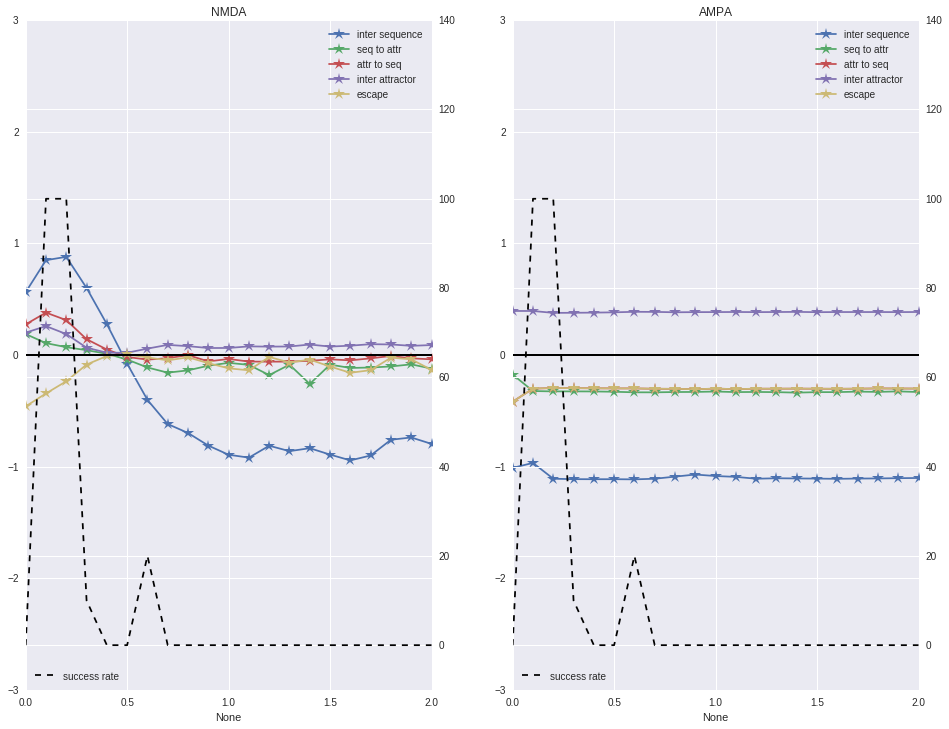

In [21]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        inter_pulse_interval_ranges, success)

print('succesfull recall', recall)

##### Effect of k_inner

In [22]:
normalize = True
ampa = False
k_inner = False
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for inter_pulse_interval in inter_pulse_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([inter_pulse_interval, success_rate])

succesfull recall [[0.0, 100.0], [0.10000000000000001, 100.0], [0.20000000000000001, 100.0], [0.30000000000000004, 0.0], [0.40000000000000002, 0.0], [0.5, 0.0], [0.60000000000000009, 0.0], [0.70000000000000007, 0.0], [0.80000000000000004, 0.0], [0.90000000000000002, 0.0], [1.0, 0.0], [1.1000000000000001, 0.0], [1.2000000000000002, 0.0], [1.3, 0.0], [1.4000000000000001, 0.0], [1.5, 0.0], [1.6000000000000001, 0.0], [1.7000000000000002, 0.0], [1.8, 0.0], [1.9000000000000001, 0.0], [2.0, 0.0]]


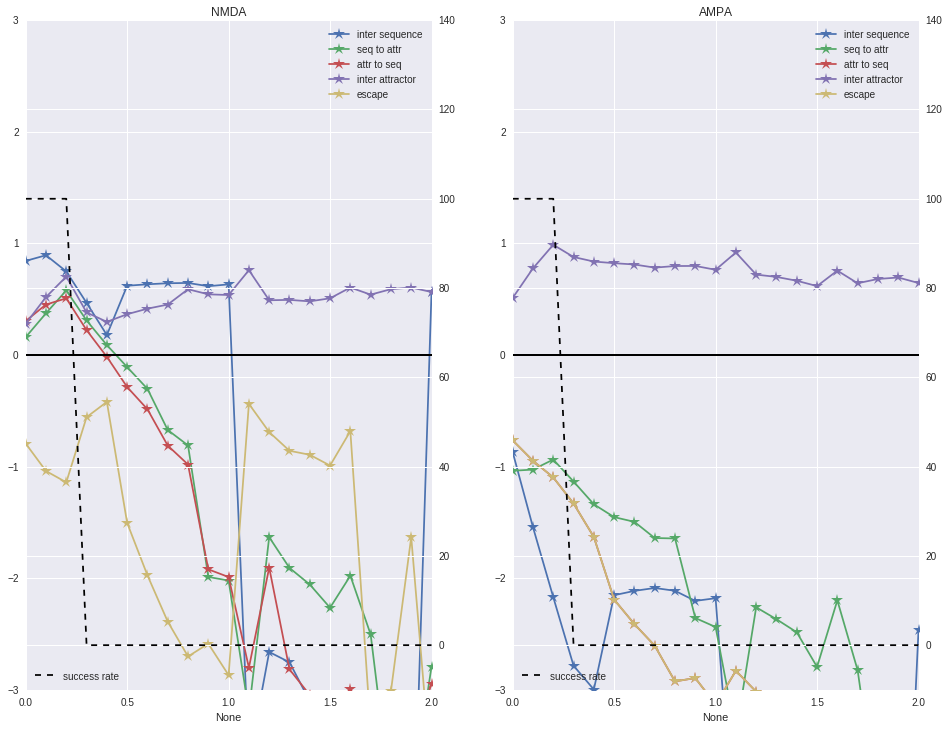

In [23]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        inter_pulse_interval_ranges, success)

print('succesfull recall', recall)

#### Effect of p

In [24]:
normalize = True
ampa = False
k_inner = True
p = 0.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for inter_pulse_interval in inter_pulse_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    patterns = [i for i in range(n_patterns)]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([inter_pulse_interval, success_rate])

succesfull recall [[0.0, 60.0], [0.10000000000000001, 100.0], [0.20000000000000001, 80.0], [0.30000000000000004, 30.0], [0.40000000000000002, 10.0], [0.5, 0.0], [0.60000000000000009, 30.0], [0.70000000000000007, 0.0], [0.80000000000000004, 0.0], [0.90000000000000002, 0.0], [1.0, 0.0], [1.1000000000000001, 0.0], [1.2000000000000002, 0.0], [1.3, 0.0], [1.4000000000000001, 0.0], [1.5, 0.0], [1.6000000000000001, 0.0], [1.7000000000000002, 0.0], [1.8, 0.0], [1.9000000000000001, 0.0], [2.0, 0.0]]


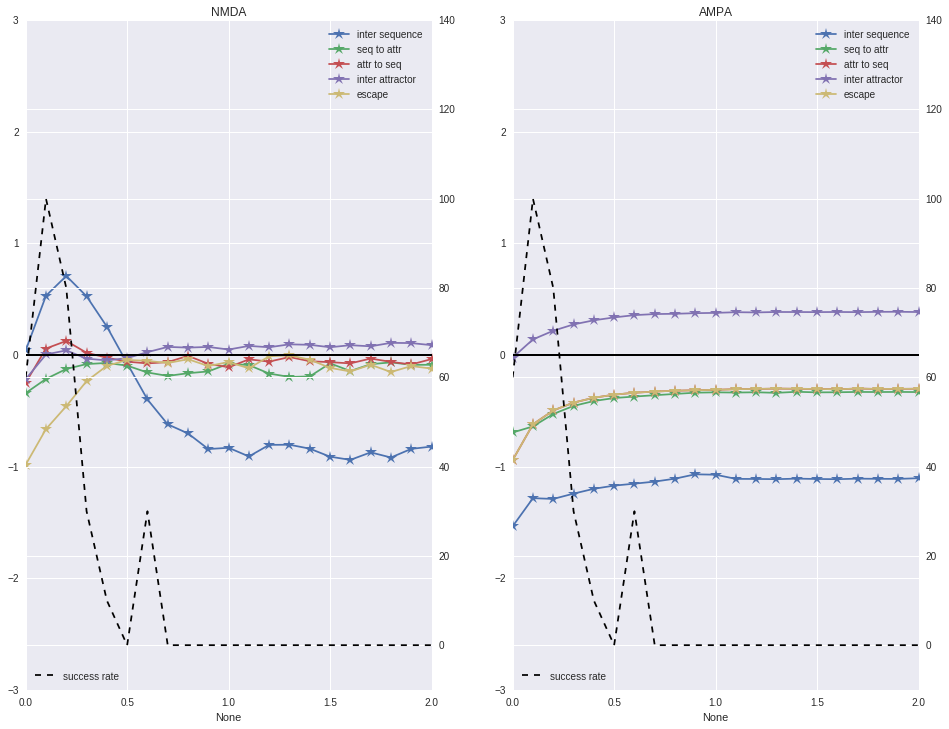

In [25]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        inter_pulse_interval_ranges, success)

print('succesfull recall', recall)

## Network size

In [26]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 5

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = [i for i in range(n_patterns)]

minicolumns_range = np.arange(10, 50, 5)

In [27]:
normalize = True
ampa = False
k_inner = False
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for minicolumns in minicolumns_range:
    n_patterns = int(minicolumns / 2)
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = [i for i in range(n_patterns)]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    patterns = [i for i in range(n_patterns)]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([minicolumns, success_rate])

succesfull recall [[10, 100.0], [15, 100.0], [20, 100.0], [25, 0.0], [30, 0.0], [35, 0.0], [40, 0.0], [45, 0.0]]


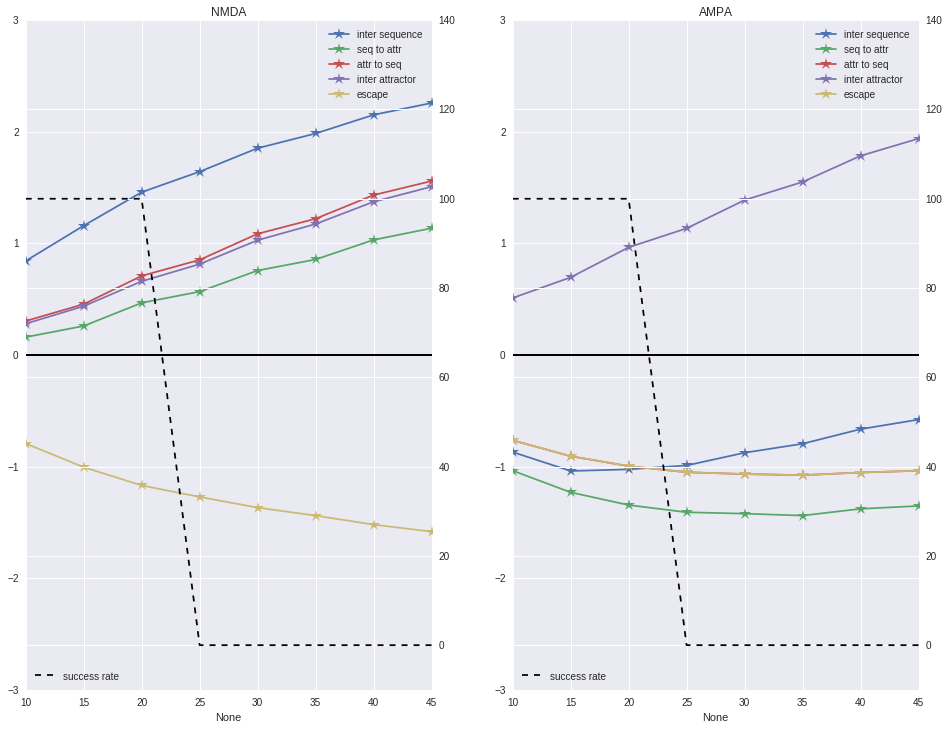

In [28]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        minicolumns_range, success)

print('succesfull recall', recall)

#### Effect of k_inner

In [29]:
normalize = True
ampa = False
k_inner = False
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for minicolumns in minicolumns_range:
    
    n_patterns = int(minicolumns / 2)
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = [i for i in range(n_patterns)]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    patterns = [i for i in range(n_patterns)]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([minicolumns, success_rate])

succesfull recall [[10, 100.0], [15, 100.0], [20, 100.0], [25, 0.0], [30, 0.0], [35, 0.0], [40, 0.0], [45, 0.0]]


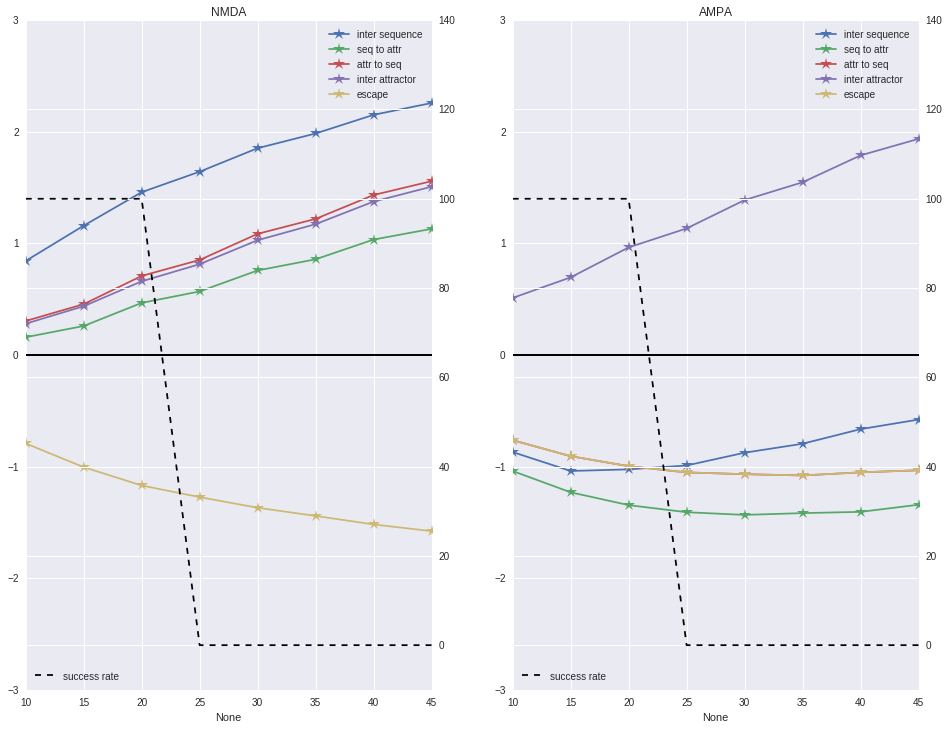

In [30]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        minicolumns_range, success)

print('succesfull recall', recall)

#### Effect of fixed n_patterns (k_inner = True)

In [31]:
normalize = True
ampa = False
k_inner = True
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

n_patterns = 5

for minicolumns in minicolumns_range:
    
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = [i for i in range(n_patterns)]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)

    # Calculate correct recall
    patterns = [i for i in range(n_patterns)]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([minicolumns, success_rate])

succesfull recall [[10, 0.0], [15, 100.0], [20, 100.0], [25, 100.0], [30, 100.0], [35, 100.0], [40, 100.0], [45, 100.0]]


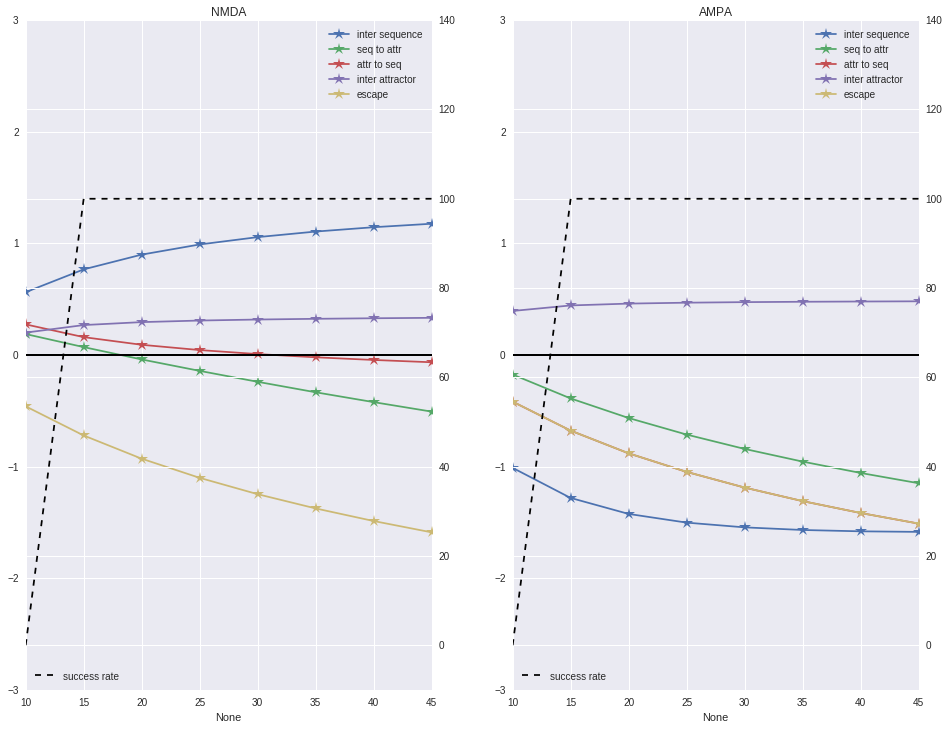

In [32]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        minicolumns_range, success)

print('succesfull recall', recall)

#### Effect of fixed n_patterns (k_inner = False)

In [33]:
normalize = True
ampa = False
k_inner = False
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

n_patterns = 5

for minicolumns in minicolumns_range:
    
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = [i for i in range(n_patterns)]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    patterns = [i for i in range(n_patterns)]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([minicolumns, success_rate])

succesfull recall [[10, 100.0], [15, 100.0], [20, 100.0], [25, 100.0], [30, 100.0], [35, 100.0], [40, 100.0], [45, 100.0]]


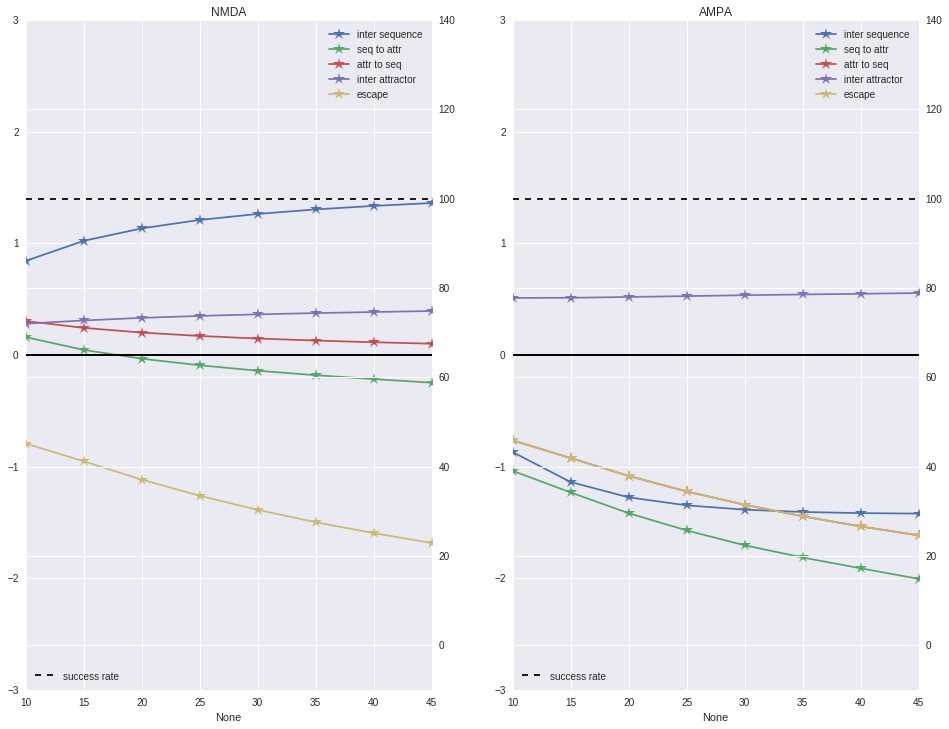

In [34]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        minicolumns_range, success)

print('succesfull recall', recall)

## Free attractor size

In [35]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 5  # Number of patterns

# Manager properties333333
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 5

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

n_patterns_range = np.arange(5, minicolumns + 5, 5)

In [36]:
normalize = True
ampa = False
k_inner = True
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []

for n_patterns in n_patterns_range:
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = [i for i in range(n_patterns)]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    patterns = [i for i in range(n_patterns)]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([n_patterns, success_rate])

../analysis_functions.py:148: RuntimeWarning: invalid value encountered in double_scalars
  weights /= norm
../analysis_functions.py:168: RuntimeWarning: invalid value encountered in double_scalars
  weights /= norm
../analysis_functions.py:206: RuntimeWarning: invalid value encountered in double_scalars
  weights /= norm
../analysis_functions.py:188: RuntimeWarning: invalid value encountered in double_scalars
  weights /= norm


succesfull recall [[5, 100.0], [10, 100.0], [15, 0.0], [20, 0.0], [25, 0.0], [30, 0.0], [35, 0.0], [40, 0.0], [45, 0.0], [50, 0.0]]


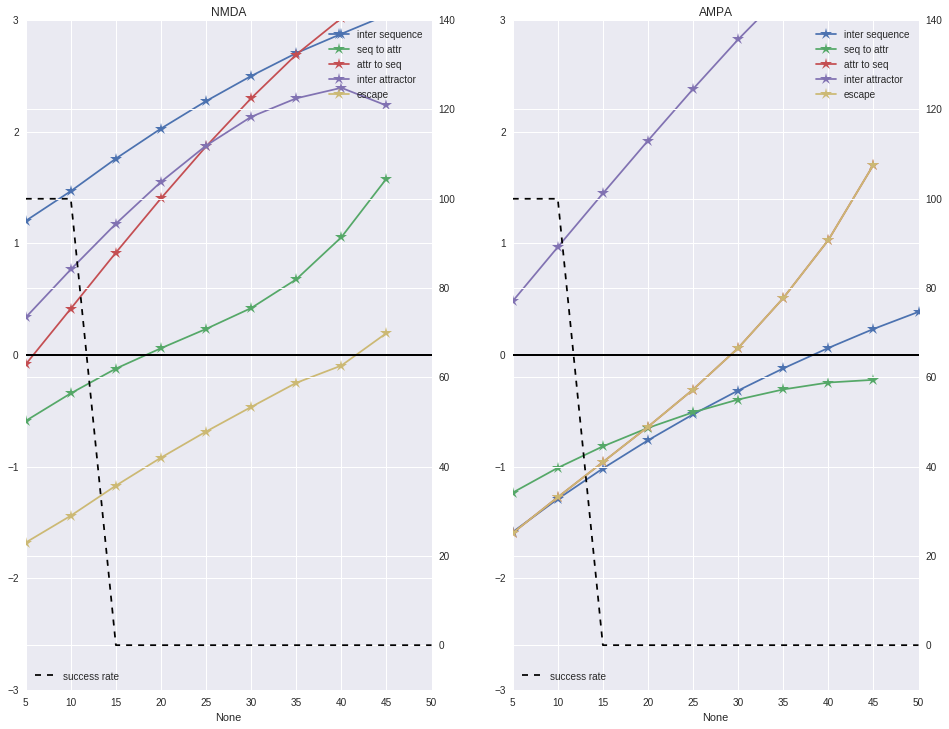

In [37]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        n_patterns_range, success)

print('succesfull recall', recall)

## Hypercolumns

In [38]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 5  # Number of patterns

# Manager properties333333
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 5

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = [i for i in range(n_patterns)]

hypercolumns_range = np.arange(5, 30, 5)

In [39]:
normalize = True
ampa = False
k_inner = True
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectivty = []
first_state_to_free_attractor_connectivity = []

inter_sequence_connectivity_ampa = []
sequence_to_free_attractor_connectivity_ampa = []
free_attractor_to_sequence_connectivity_ampa = []
inter_free_attractor_connectivty_ampa = []
first_state_to_free_attractor_connectivity_ampa = []

recall = []
for hypercolumns in hypercolumns_range:
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = [i for i in range(n_patterns)]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    calculate_connectivities(manager, inter_sequence_connectivity, sequence_to_free_attractor_connectivity,
                            free_attractor_to_sequence_connectivity, inter_free_attractor_connectivty,
                            first_state_to_free_attractor_connectivity, ampa=False, normalize=normalize)
    
    calculate_connectivities(manager, inter_sequence_connectivity_ampa, sequence_to_free_attractor_connectivity_ampa,
                            free_attractor_to_sequence_connectivity_ampa, inter_free_attractor_connectivty_ampa,
                            first_state_to_free_attractor_connectivity_ampa, ampa=True, normalize=normalize)
    
    # Calculate correct recall
    patterns = [i for i in range(n_patterns)]
    success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, patterns_indexes=patterns)
    recall.append([hypercolumns, success_rate])

succesfull recall [[5, 100.0], [10, 0.0], [15, 0.0], [20, 0.0], [25, 0.0]]


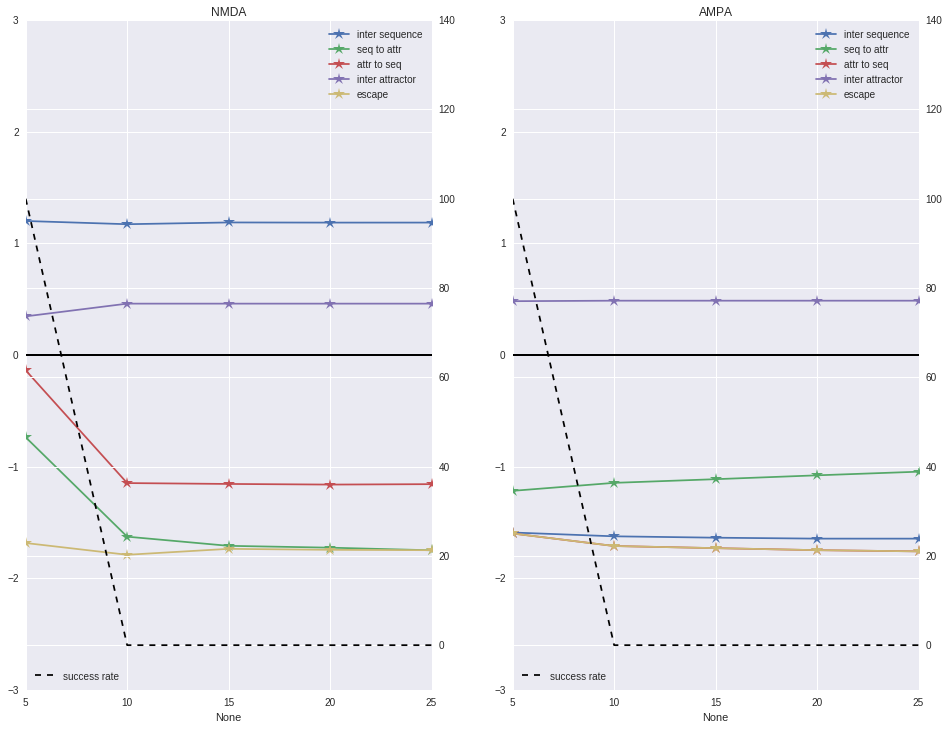

In [40]:
success = [x[1] for x in recall]
plot_connectivities(inter_sequence_connectivity, inter_sequence_connectivity_ampa,
                        sequence_to_free_attractor_connectivity, sequence_to_free_attractor_connectivity_ampa,
                        free_attractor_to_sequence_connectivity, free_attractor_to_sequence_connectivity_ampa, 
                        inter_free_attractor_connectivty, inter_free_attractor_connectivty_ampa, 
                        first_state_to_free_attractor_connectivity, first_state_to_free_attractor_connectivity_ampa,
                        hypercolumns_range, success)

print('succesfull recall', recall)

#### Git recovery

In [41]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])